In [2]:
import cv2 as cv
import torch
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from fft_conv_pytorch import fft_conv, FFTConv2d
import math
import gc

In [3]:
def two_n_squareify(tensor):
    # This function takes a tensor and pads it with zeros until the dimensions are a power of 2
    # The return tensor is a square tensor
    
    # Find the next power of 2
    next_power = max(2**math.ceil(math.log2(len(tensor[0,:,0]))), 2**math.ceil(math.log2(len(tensor[0,0,:]))))
    
    # Find the amount of padding needed
    x_pad = next_power - len(tensor[0,:,0])
    y_pad = next_power - len(tensor[0,0,:])
    
    # Check to see if it's even or odd
    if x_pad % 2 == 0:
        l_x_pad = int(x_pad/2)
        r_x_pad = int(x_pad/2)
    else:
        l_x_pad = int(x_pad/2)
        r_x_pad = x_pad - int(x_pad/2)
    
    if y_pad % 2 == 0:
        l_y_pad = int(y_pad/2)
        r_y_pad = int(y_pad/2)
    else:
        l_y_pad = int(y_pad/2)
        r_y_pad = y_pad - int(y_pad/2)
    
    return_tensor = torch.nn.functional.pad(tensor, (l_y_pad, r_y_pad, l_x_pad, r_x_pad), "constant", 0)
    
    return return_tensor

In [4]:
image = two_n_squareify(torch.from_numpy(np.array(cv.imread(r'./test_images/img_time1_1.tif', cv.IMREAD_GRAYSCALE))).to(torch.float32).unsqueeze(0))

In [5]:
forward = two_n_squareify(torch.permute(torch.load(r'./models_DONOTCOMMIT/test_models/forward.pt'), (2,0,1)).to(torch.float32))

In [6]:
forward[:,:,:] = torch.div(forward[:,:,:], torch.sum(forward[:,:,:], dim=(1,2)).unsqueeze(1).unsqueeze(2))

In [7]:
print(image.shape, forward.shape)

torch.Size([1, 8192, 8192]) torch.Size([20, 8192, 8192])


In [8]:
torch.cuda.empty_cache()

In [9]:
backward = torch.transpose(forward, 1, 2)

In [10]:
print(backward.shape)

torch.Size([20, 8192, 8192])


In [11]:
def fft_convolve_images(image, kernel_stack, summation = False):
    # image is the image to be convolved
    # kernel_stack is the stack of kernels to be convolved with the image
    
    # The image and the kernel stack should be the same size
    # The kernel stack should be in the format [depth, x, y]
    return_tensor = torch.fft.ifftshift(torch.fft.ifft2(torch.mul(torch.fft.fft2(image), torch.fft.fft2(torch.div(kernel_stack, torch.sum(kernel_stack, dim = (1,2)).unsqueeze(1).unsqueeze(2)))), dim = (1,2))) # Convolve the image with the kernel stack
        
    if summation == True:
        return_tensor = torch.sum(return_tensor, 0) # Sum all of the convolutions
    
    return return_tensor

In [12]:
torch.backends.cudnn.deterministic=True

In [13]:
gc.collect()

16

In [14]:
torch.cuda.empty_cache()

In [36]:
single_conv = FFTConv2d(1, 1, kernel_size = 8192, stride = 1, padding = 'same', bias = False)

In [37]:
torch.cuda.empty_cache()
gc.collect()

0

In [38]:
conv = torch.empty((1,8192, 8192)).to('cuda')
for i in range(len(forward[:,0,0])):
    with torch.no_grad():
        single_conv.weight = torch.nn.Parameter(forward[i,:,:].unsqueeze(0).detach().to('cuda'))
        conv += single_conv(image.to('cuda').detach())
        torch.cuda.empty_cache()
        gc.collect()

In [39]:
print(conv)

tensor([[[19.0891, 19.0672, 19.1015,  ...,  0.0253,  0.0235,  0.0216],
         [19.0891, 19.0672, 19.1015,  ...,  0.0253,  0.0235,  0.0216],
         [19.0891, 19.0672, 19.1015,  ...,  0.0253,  0.0235,  0.0216],
         ...,
         [19.0891, 19.0672, 19.1015,  ...,  0.0253,  0.0235,  0.0216],
         [19.0891, 19.0672, 19.1015,  ...,  0.0253,  0.0235,  0.0216],
         [19.0891, 19.0672, 19.1015,  ...,  0.0253,  0.0235,  0.0216]]],
       device='cuda:0')


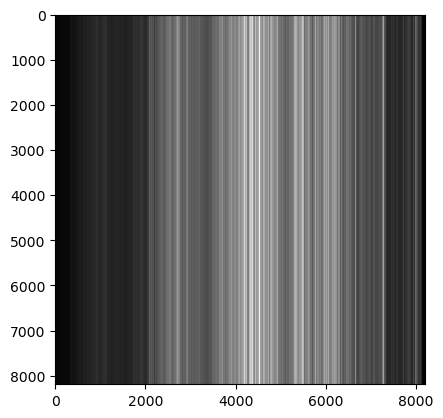

In [41]:
plt.imshow(conv[0,:,:].cpu().detach(), cmap = 'gray')

In [34]:
print(forward[0,:,:].shape)

torch.Size([8192, 8192])
